In [1]:
%pip install -U torchvision
import torch
from tqdm.auto import tqdm, trange
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np

     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
class tanh_discr(torch.autograd.Function):
    '''
    Implementation of discretized 𝑡𝑎𝑛ℎ activation functions.
    Returns value from -1 to +1
    In backward pass behaves as ordinary tanh

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Parameters:
        - n - discretization parameter

    References:
        - See related paper:
        https://arxiv.org/pdf/2105.01768.pdf

    Examples:
        >>> x = torch.randn(256)
        >>> x = tanh_discr.apply(x, 256)
    '''
    @staticmethod
    def forward(ctx, x, n=2):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        th = torch.tanh(x)
        ctx.save_for_backward(th)
        _n = (n-1)/2
        return torch.round(_n + _n * th) / _n - 1
    
    @staticmethod
    def backward(ctx, grad_output):
        th, = ctx.saved_tensors
        return (1 - th ** 2) * grad_output, None

class PreEncoder(nn.Module):
    def __init__(self, num_layers=6, num_channels=64, kernel_size=5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv2d(3, num_channels, kernel_size, padding='same')])
        for i in range(num_layers - 1):
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size, padding='same'))

    def forward(self, x):
        for conv in self.convs:
            x = torch.tanh(conv(x))
        return x

class DownDiscretizationEncoder(nn.Module):
    def __init__(self, kernel_size=5, input_channels = 64):
        super().__init__()
        num_layers=8
        self.convs = nn.ModuleList([nn.Conv2d(input_channels, 1, kernel_size, padding='same')])
        for i in range(num_layers - 1):
            self.convs.append(nn.Conv2d(1, 1, kernel_size, padding='same'))
        
    def forward(self, x):
        for removed_bits, conv in enumerate(self.convs):
            x = tanh_discr.apply(conv(x), 2 ** (8 - removed_bits))
        return x

class Decoder(nn.Module):
    def __init__(self, num_layers=2, num_channels=64, kernel_size=5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv2d(1, num_channels, kernel_size, padding='same')])
        for i in range(num_layers - 2):
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size, padding='same'))
        self.convs.append(nn.Conv2d(num_channels, 3, kernel_size, padding='same'))

    def forward(self, x):
        for conv in self.convs[:-1]:
            x = F.relu(conv(x))
        x = torch.tanh(self.convs[-1](x))
        return x

class TexturesModel(nn.Module):
    def __init__(self, num_layers=6, num_channels=64, kernel_size=5, alpha=0.1, beta=0.1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.pre_encoder = PreEncoder(num_layers, num_channels, kernel_size=kernel_size)
        self.dde = DownDiscretizationEncoder(input_channels=num_channels, kernel_size=kernel_size)
        self.decoder = Decoder(num_layers, num_channels, kernel_size=kernel_size)

    def forward(self, x):
        x = self.pre_encoder(x)
        x = self.dde(x)
        return x

    def decode(self, x):
        x = self.decoder(x)
        return x



In [5]:
import torchvision.transforms as transforms
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose(
    [transforms.ToTensor()])

stl_data = torchvision.datasets.STL10(root='./stl_data', transform=transform, split='unlabeled', download=True)
stl_loader = torch.utils.data.DataLoader(stl_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# celeba_data = torchvision.datasets.CelebA(root='/celeba_data', split='train', transform=transform, download=True)
# celeba_loader = torch.utils.data.DataLoader(celeba_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

size = 150
cropping_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomCrop((size,size))])

cars_data = torchvision.datasets.StanfordCars(root='./cars_data', download=True)
from pathlib import Path
from PIL import Image
cars_dir=Path('./cars_data/stanford_cars/cars_train/')
removed = 0
for filename in cars_dir.iterdir():
  img = Image.open(filename)
  if min(img.size) < size:
    filename.unlink() # remove file
    removed += 1
print(f"Removed {removed} files")

cars_data = torchvision.datasets.StanfordCars(root='./cars_data', download=False, transform=cropping_transform)
cars_loader = torch.utils.data.DataLoader(cars_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())


size = 350
cropping_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomCrop((size,size))])

nature_data = torchvision.datasets.INaturalist(root='./nature_data', version='2021_valid', target_type='kingdom', download=True)

nature_dir=Path('./nature_data/2021_valid/')
removed = 0
for dirname in nature_dir.iterdir():
  for filename in dirname.iterdir():
    img = Image.open(filename)
    if min(img.size) < size:
      filename.unlink() # remove file/
      removed += 1
  if not list(dirname.iterdir()):
    dirname.rmdir()
print(f"Removed {removed} files")

nature_data = torchvision.datasets.ImageFolder(root='./nature_data/2021_valid', transform=cropping_transform)
nature_loader = torch.utils.data.DataLoader(nature_data, batch_size=batch_size//2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# imagenet_data = torchvision.datasets.ImageNet('./imagenet_data', download=True, transform=transforms.ToTensor(), split='val')
# imagenet_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())


Files already downloaded and verified
Removed 0 files


  0%|          | 0/8931661582 [00:00<?, ?it/s]

Extracting ./nature_data/2021_valid.tgz to ./nature_data
Dataset version '2021_valid' has been downloaded and prepared for use
Removed 29905 files


In [7]:
import torch.optim as optim

# net = torch.load('./model.torch').to(device)
net = TexturesModel().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [8]:
loader = nature_loader
torch.cuda.empty_cache()
color_shift = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)

for epoch in trange(1):  # loop over the dataset multiple times
    epoch_loss = 0
    for batch, data in tqdm(enumerate(loader), leave=False, total=len(loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute loss
        encoded = net(inputs)
        decoded = net.decode(encoded)
        restoration_loss = F.mse_loss(inputs, decoded)

        stride = 8
        input_brightness = F.avg_pool2d(inputs.mean(axis=1, keepdims=True) * 2 - 1, 8, stride=stride).ravel()
        in_brt_diffs = input_brightness - input_brightness.T
        # in_brt_diffs = (in_brt_diffs - (in_brt_diffs.min() + in_brt_diffs.max()) / 2) / \
        #                          (in_brt_diffs.max() - in_brt_diffs.min()) * 2
        encoded_brghtness = F.avg_pool2d(encoded/2 + 0.5, 8, stride=stride).ravel()
        enc_brt_diffs = encoded_brghtness - encoded_brghtness.T
        # enc_brt_diffs = (enc_brt_diffs - (enc_brt_diffs.min() + enc_brt_diffs.max()) / 2) / \
        #                           (enc_brt_diffs.max() - enc_brt_diffs.min()) * 2
        intensicy_loss = (torch.tanh(in_brt_diffs) - torch.tanh(enc_brt_diffs)).abs().mean()

        color_continuity_loss = F.mse_loss(encoded, net(color_shift(inputs)))

        total_loss = restoration_loss + net.alpha * intensicy_loss + net.beta * color_continuity_loss
        total_loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            print(f"batch: {batch}, batch loss: {total_loss:>7f}")

        epoch_loss += total_loss.cpu().detach()
    tqdm.write("=====================================")
    tqdm.write(f"Epoch {epoch}, loss {epoch_loss}")
    tqdm.write("=====================================")
    tqdm.write("=====================================")


print('Finished Training')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8762 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)


batch: 0, batch loss: 0.275081


KeyboardInterrupt: ignored

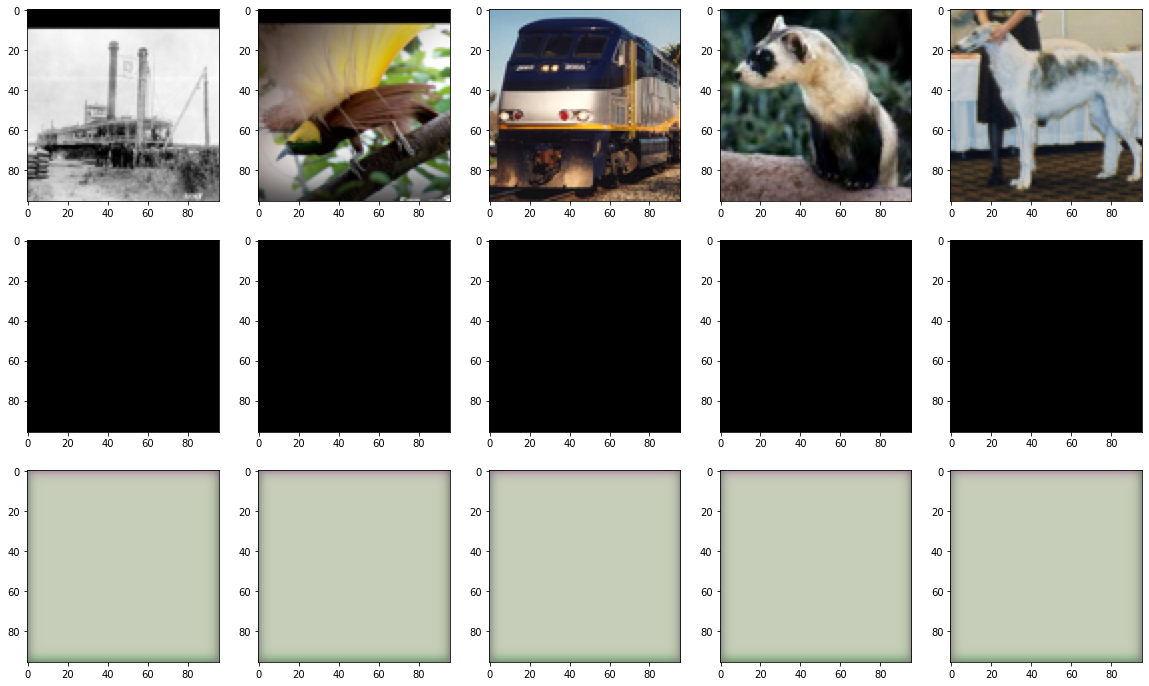

In [ ]:
for loader in [stl_loader, nature_loader, cars_loader]:
    train_features, train_labels = next(iter(loader))
    compressed = net(train_features.to(device))
    decoded = net.decode(compressed)
    num = min(batch_size, 5)
    fig, axs = plt.subplots(3, num, figsize=(num * 4, 3 * 4))
    for i in range(num):
        img = train_features[i].squeeze()
        axs[0, i].imshow(np.moveaxis(img.numpy(), 0, -1))
        axs[1, i].imshow(np.squeeze(compressed[i].cpu().detach().numpy(), 0) * 255, cmap='gray')
        axs[2, i].imshow(np.moveaxis(decoded[i].cpu().detach().numpy() / 2 + 0.5, 0, -1))
    plt.show()

In [ ]:
torch.save(net, "./model.torch")